In [47]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

In [48]:
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

In [49]:
tqdm.pandas(desc='Progress')
from collections import Counter

C:\Users\Dyuti\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [50]:
from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 



In [51]:
import keras
from keras.preprocessing.sequence import pad_sequences

In [52]:
# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [98]:
#Hyperparameter Setting
embed_size = 300 # how big is each word vector
max_features = 12000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use
batch_size = 500 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [54]:
#Import Train Dataset and provide location of the CSV file
trainDf = pd.read_csv("C:/Users/Dyuti/Documents/Text/train.csv")

In [55]:
#Import Test Dataset and provide location of the CSV file
testDf = pd.read_csv("C:/Users/Dyuti/Documents/Text/test.csv")

In [56]:
trainDf

,Unnamed: 0,Question_Asked,Agency
0,0,eForm 16 and V103,ICA
1,1,What is the latest new update of number plate,LTA
2,2,need to know further about Benefit In kind,IRAS IIT
3,3,how to filling individual tax return,IRAS IIT
4,4,can not reopen XBRL zipped file,ACRA
...,...,...,...
353920,353920,Search fees for notice of assessment,IRAS IIT
353921,353921,How do I did fix an appointment to see the tax...,IRAS IIT
353922,353922,I have make an appointment can I collect my pa...,ICA
353923,353923,hi in how many pixels should the photo for app...,ICA


In [124]:
testDf

,Unnamed: 0,Question_Asked,Agency
0,0,how to excuse ippt,MINDEF
1,1,how to refer wild animals found in public or p...,AVA
2,2,hi can i check if the talent area of each seco...,MOE
3,3,how to find courses and get funding support,SSG
4,4,ais extension,IRAS IIT
...,...,...,...
88477,88477,i wanna ask about jae,MOE
88478,88478,hi can i sent in my car for inspection without...,LTA
88479,88479,iras help line number,IRAS IIT
88480,88480,how do i declare rental income for hdb flat on...,IRAS IIT


In [59]:
#Length of Question Asked in Train
trainDf['len'] = trainDf['Question_Asked'].apply(lambda s : len(s))

In [60]:
# Max Length
max(testDf.len)

98.0

In [61]:
#Frequency of Questions across Agencies in Train
count_trainDf = trainDf[['Agency','Question_Asked']].groupby('Agency').aggregate({'Question_Asked':'count'}).reset_index().sort_values('Question_Asked',ascending=False)
count_trainDf

,Agency,Question_Asked
4,IRAS IIT,59829
2,ICA,58427
5,LTA,48374
0,ACRA,43587
8,SPF,35222


In [62]:
trainDf.Agency.unique()

array(['ICA', 'LTA', 'IRAS IIT', 'ACRA', 'MINDEF', 'SPF', 'SSG',
       'IRAS GST', 'AVA', 'MOE'], dtype=object)

<AxesSubplot:>

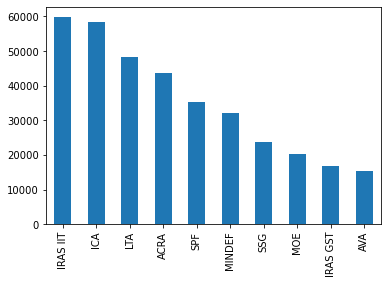

In [63]:
trainDf.Agency.value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Frequency'>

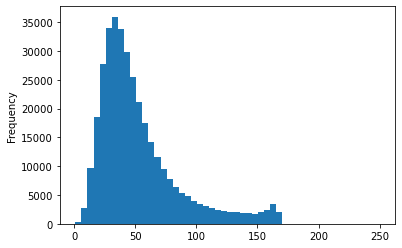

In [118]:
trainDf['len'].plot.hist(bins=50)

In [65]:
count_trainDf

,Agency,Question_Asked
4,IRAS IIT,59829
2,ICA,58427
5,LTA,48374
0,ACRA,43587
8,SPF,35222
6,MINDEF,32252
9,SSG,23794
7,MOE,20389
3,IRAS GST,16819
1,AVA,15232


In [66]:
#Functions for cleaning Text
import re

def clean_text(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(pattern, '', text)
    text = text.strip(' ')
    return text

def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        x = re.sub('[0-9]{4}', '####', text)
        x = re.sub('[0-9]{3}', '###', text)
        x = re.sub('[0-9]{2}', '##', text)
    return text

In [67]:
# lower the text
trainDf["Question_Asked"] = trainDf["Question_Asked"].apply(lambda x: x.lower())

# Clean the text
trainDf["Question_Asked"] = trainDf["Question_Asked"].apply(lambda x: clean_text(x))

# Clean numbers
trainDf["Question_Asked"] = trainDf["Question_Asked"].apply(lambda x: clean_numbers(x))

In [68]:
trainDf.head()

,Unnamed: 0,Question_Asked,Agency,len
0,0,eform ## and v###,ICA,17
1,1,what is the latest new update of number plate,LTA,45
2,2,need to know further about benefit in kind,IRAS IIT,42
3,3,how to filling individual tax return,IRAS IIT,36
4,4,can not reopen xbrl zipped file,ACRA,31


In [69]:
# lower the text
testDf["Question_Asked"] = testDf["Question_Asked"].apply(lambda x: x.lower())

# Clean the text
testDf["Question_Asked"] = testDf["Question_Asked"].apply(lambda x: clean_text(x))

# Clean numbers
testDf["Question_Asked"] = testDf["Question_Asked"].apply(lambda x: clean_numbers(x))

In [70]:
testDf.head()

,Unnamed: 0,Question_Asked,Agency
0,0,how to excuse ippt,MINDEF
1,1,how to refer wild animals found in public or p...,AVA
2,2,hi can i check if the talent area of each seco...,MOE
3,3,how to find courses and get funding support,SSG
4,4,ais extension,IRAS IIT


In [39]:
#Remove Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
stop = stopwords.words('english')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dyuti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
trainDf.head()

,Unnamed: 0,Question_Asked,Agency,len
0,0,eform ## and v###,ICA,17
1,1,what is the latest new update of number plate,LTA,45
2,2,need to know further about benefit in kind,IRAS IIT,42
3,3,how to filling individual tax return,IRAS IIT,36
4,4,can not reopen xbrl zipped file,ACRA,31


In [84]:
trainDf['Question_Asked'].apply(lambda x: [item for item in x if item not in stop])
testDf['Question_Asked'].apply(lambda x: [item for item in x if item not in stop])

0                     [h, w,  ,  , e, x, c, u, e,  , p, p]
1        [h, w,  ,  , r, e, f, e, r,  , w, l,  , n, l, ...
2        [h,  , c, n,  ,  , c, h, e, c, k,  , f,  , h, ...
3        [h, w,  ,  , f, n,  , c, u, r, e,  , n,  , g, ...
4                                       [ , e, x, e, n, n]
                               ...                        
88477                 [ , w, n, n,  , k,  , b, u,  , j, e]
88478    [h,  , c, n,  ,  , e, n,  , n,  ,  , c, r,  , ...
88479     [r,  , h, e, l, p,  , l, n, e,  , n, u, b, e, r]
88480    [h, w,  ,  ,  , e, c, l, r, e,  , r, e, n, l, ...
88481                       [e,  , w, h, p,  , p,  , x, e]
Name: Question_Asked, Length: 88482, dtype: object

In [85]:
trainDf.head()

,Unnamed: 0,Question_Asked,Agency,len
0,0,eform ## and v###,ICA,17
1,1,what is the latest new update of number plate,LTA,45
2,2,need to know further about benefit in kind,IRAS IIT,42
3,3,how to filling individual tax return,IRAS IIT,36
4,4,can not reopen xbrl zipped file,ACRA,31


In [86]:
#Separate out X and Y for Train and Test
train_X, test_X, train_y, test_y = trainDf['Question_Asked'], testDf['Question_Asked'],trainDf['Agency'], testDf['Agency']

In [87]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (353925,)
Test shape :  (88482,)


In [88]:
from keras.preprocessing.text import Tokenizer

In [89]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [90]:
train_X

array([[   0,    0,    0, ..., 3207,   17, 1356],
       [   0,    0,    0, ...,   11,   44,  289],
       [   0,    0,    0, ...,  958,   12,  826],
       ...,
       [   0,    0,    0, ...,    5,  173,   84],
       [   0,    0,    0, ...,  269,   40,   34],
       [   0,    0,    0, ...,   15,    8, 1696]])

In [91]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [92]:
le.classes_

array(['ACRA', 'AVA', 'ICA', 'IRAS GST', 'IRAS IIT', 'LTA', 'MINDEF',
       'MOE', 'SPF', 'SSG'], dtype=object)

In [101]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule for Embedding

def load_glove(word_index):
    EMBEDDING_FILE = 'C:/Users/Dyuti/Documents/Text/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding="utf8"))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [102]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

C:\Users\Dyuti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [103]:
np.shape(embedding_matrix)

(43767, 300)

In [104]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [115]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
#model()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)
y_train = torch.tensor(train_y, dtype=torch.long)
x_cv = torch.tensor(test_X, dtype=torch.long)
y_cv = torch.tensor(test_y, dtype=torch.long)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

In [116]:
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []


In [117]:
for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\Dyuti\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=360.1228 	 val_loss=194.5066  	 val_acc=0.8843  	 time=1184.61s
Epoch 2/6 	 loss=179.5582 	 val_loss=161.5717  	 val_acc=0.9025  	 time=1107.44s
Epoch 3/6 	 loss=154.0449 	 val_loss=150.4100  	 val_acc=0.9093  	 time=1129.63s
Epoch 4/6 	 loss=138.5939 	 val_loss=146.3770  	 val_acc=0.9106  	 time=1108.82s
Epoch 5/6 	 loss=127.0441 	 val_loss=138.9569  	 val_acc=0.9159  	 time=1116.40s
Epoch 6/6 	 loss=118.1732 	 val_loss=135.8005  	 val_acc=0.9180  	 time=1158.51s


In [120]:
torch.save(model,'bilstm_model')

C:\Users\Dyuti\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Dyuti\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Dyuti\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Dyuti\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Dyuti\

In [122]:
#import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]

In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred,target_names=testDf['Agency'].unique()))

              precision    recall  f1-score   support

      MINDEF       0.92      0.92      0.92     10899
         AVA       0.90      0.88      0.89      3805
         MOE       0.94      0.95      0.95     14605
         SSG       0.96      0.85      0.90      4207
    IRAS IIT       0.88      0.95      0.91     14943
        ACRA       0.93      0.93      0.93     12093
         LTA       0.90      0.89      0.90      8072
         ICA       0.94      0.90      0.92      5101
         SPF       0.92      0.91      0.92      8803
    IRAS GST       0.92      0.90      0.91      5954

    accuracy                           0.92     88482
   macro avg       0.92      0.91      0.91     88482
weighted avg       0.92      0.92      0.92     88482



In [125]:
testDf['Prediction'] = y_pred
testDf.head()

,Unnamed: 0,Question_Asked,Agency,Prediction
0,0,how to excuse ippt,MINDEF,MINDEF
1,1,how to refer wild animals found in public or p...,AVA,AVA
2,2,hi can i check if the talent area of each seco...,MOE,MOE
3,3,how to find courses and get funding support,SSG,SSG
4,4,ais extension,IRAS IIT,IRAS IIT


In [126]:
#export as CSV
testDf.to_csv("C:/Users/Dyuti/Documents/Text/LSTM_prediction.csv")